# Backtesting with a Gap
### Single and Multiple Independent time-series: Direct & Recursive forecasting
Note: The arguments needed to achieve this configuration are `gap=n` and `refit=True` and `fixed_train_size=False`.   
Conda environment: `time-series`  
12 Jul 2024

![image](/Users/razielar/Documents/git_rep/personal_repos/forecasting_with_ml/img/backtesting/backtesting_refit_gap.gif)

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Single time series

In [5]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222
...,...,...,...,...
190,2008-02-01,0.7618,1.5158,1.7864
191,2008-03-01,0.6494,1.5063,1.6943
192,2008-04-01,0.8279,1.5053,1.6271
193,2008-05-01,0.8163,1.4915,1.5551


In [6]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [7]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


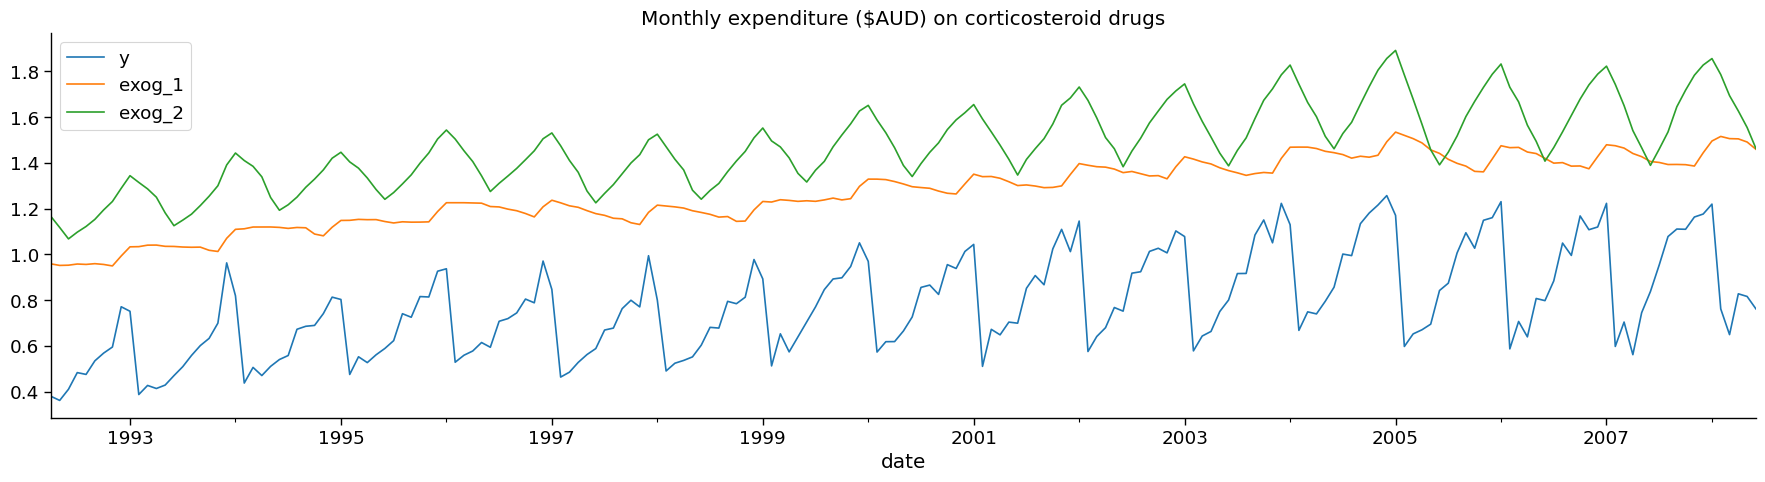

In [8]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")
plt.show()

### 1.2) Direct Forecasting

In [16]:
# Number of steps to forecast. 
# This needs to include the size of the gap. If we want a gap of 3, and forecast 7 steps after the gap we need to set steps=10.
steps = 10

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=steps,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Initial training set size
initial_train_size = 100

# Gap between train and test
gap = 3

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    gap=gap,
    steps=steps - gap,  # This needs to be the size of the test set. 
    metric="mean_squared_error",
    refit=True,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric: .4f}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 100
Number of observations used for backtesting: 95
    Number of folds: 14
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 3
    Last fold only includes 1 observations.

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2000-07-01 00:00:00  (n=100)
    Validation: 2000-11-01 00:00:00 -- 2001-05-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2001-02-01 00:00:00  (n=107)
    Validation: 2001-06-01 00:00:00 -- 2001-12-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2001-09-01 00:00:00  (n=114)
    Validation: 2002-01-01 00:00:00 -- 2002-07-01 00:00:00  (n=7)
Fold: 3
    Training:   1992-04-01 00:00:00 -- 2002-04-01 00:00:00  (n=121)
    Validation: 2002-08-01 00:00:00 -- 2003-02-01 00:00:00  (n=7)
Fold: 4
    Training:   1992-04-01 00:00:00 -- 2002-11-01 00:00:00  (n=128)


/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/skforecast/model_selection/model_selection.py:554: LongTrainingWarning: The forecaster will be fit 140 times (14 folds * 10 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

Backtest metric (MSE):  0.0121


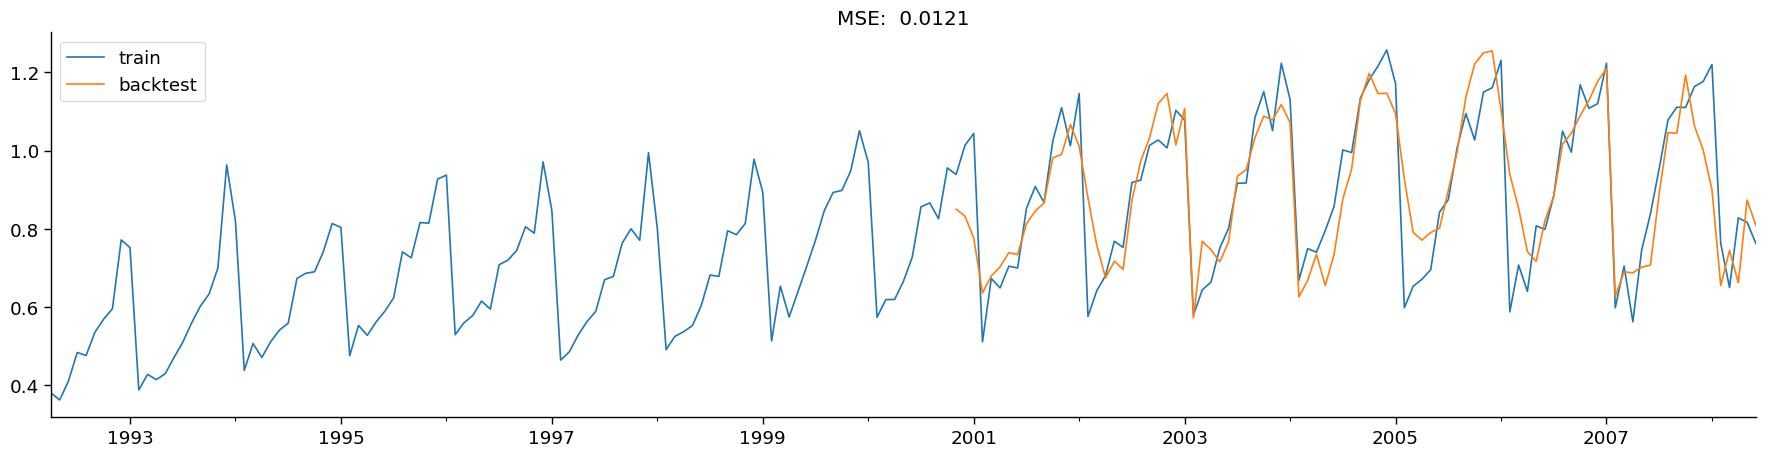

In [17]:
error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

fig, ax = plt.subplots()
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend()

plt.title(f"MSE: {error_mse: .4f}")
plt.xlabel("")
plt.show()

## 2) Multiple Independent time-series